json 처리하기

In [1]:
import json

In [2]:
with open('/content/sarcasm.json') as f:
  datastore = json.load(f)
  # for item in data:
  #   print(item['article_link'],item['headline'],item['is_sarcastic'])

데이터 전처리

In [3]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
import tensorflow as tf

In [4]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]
table = str.maketrans('','', string.punctuation)  # string.punctuation 포함된 문자를 제거

In [5]:
sentences = []
labels = []
urls = []
for item in datastore:
  sentence = item['headline'].lower()
  sentence = sentence.replace(',',' , ')
  sentence = sentence.replace('.',' . ')
  sentence = sentence.replace('-',' - ')
  sentence = sentence.replace('/',' / ')
  soup = BeautifulSoup(sentence)
  sentence = soup.get_text()
  words = sentence.split()
  filtered_sentence = ""
  for word in words:
    word = word.translate(table)
    if word not in stopwords:
      filtered_sentence = filtered_sentence + word + " "
  sentences.append(filtered_sentence)
  labels.append(item['is_sarcastic'])
  urls.append(item['article_link'])

<ipython-input-5-500dffd6eb10>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


In [6]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [27]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

텐서플로 임베딩

In [9]:
import numpy as np
training_padding = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padding = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [10]:
model = tf.keras.Sequential([
 tf.keras.layers.Embedding(vocab_size,embedding_dim),
 tf.keras.layers.GlobalAveragePooling1D(),  # 시퀀스의 길이에 상관없이 각 시퀀스의 평균 임베딩 계산
 tf.keras.layers.Dense(24, activation='relu'),
 tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
num_epochs = 30
history = model.fit(training_padding,training_labels,epochs=num_epochs,
                    validation_data = (testing_padding,testing_labels))

Epoch 1/30
719/719 [==============================] - 18s 21ms/step - loss: 0.6808 - accuracy: 0.5598 - val_loss: 0.6519 - val_accuracy: 0.5791
Epoch 2/30
719/719 [==============================] - 4s 5ms/step - loss: 0.5406 - accuracy: 0.7436 - val_loss: 0.4835 - val_accuracy: 0.7795
Epoch 3/30
719/719 [==============================] - 4s 5ms/step - loss: 0.3948 - accuracy: 0.8299 - val_loss: 0.4294 - val_accuracy: 0.7972
Epoch 4/30
719/719 [==============================] - 4s 6ms/step - loss: 0.3292 - accuracy: 0.8591 - val_loss: 0.4184 - val_accuracy: 0.8083
Epoch 5/30
719/719 [==============================] - 4s 5ms/step - loss: 0.2909 - accuracy: 0.8794 - val_loss: 0.4244 - val_accuracy: 0.8088
Epoch 6/30
719/719 [==============================] - 3s 4ms/step - loss: 0.2616 - accuracy: 0.8933 - val_loss: 0.4336 - val_accuracy: 0.8080
Epoch 7/30
719/719 [==============================] - 3s 4ms/step - loss: 0.2415 - accuracy: 0.9018 - val_loss: 0.4494 - val_accuracy: 0.8008
Epoc

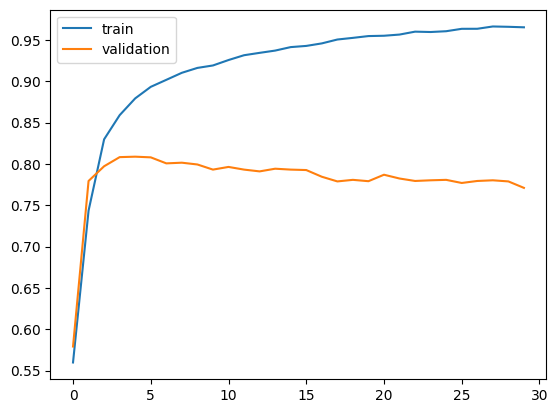

In [13]:
# accuracy , val_accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()
plt.show()

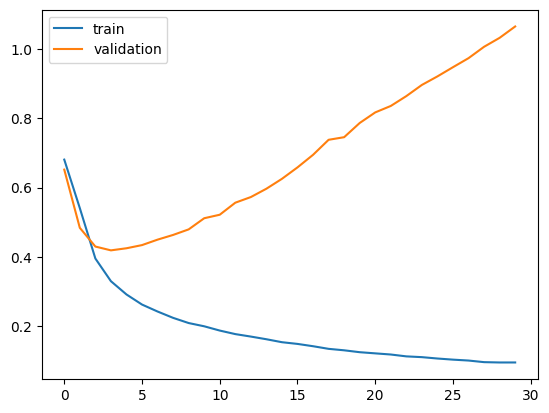

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()

과적합 해결
  - 학습률 조정

In [15]:
model = tf.keras.Sequential([
 tf.keras.layers.Embedding(vocab_size,embedding_dim),
 tf.keras.layers.GlobalAveragePooling1D(),  # 시퀀스의 길이에 상관없이 각 시퀀스의 평균 임베딩 계산
 tf.keras.layers.Dense(24, activation='relu'),
 tf.keras.layers.Dense(1, activation='sigmoid')
])
# beta_1 이동평균  이전 그레이디언트의 감소비율 설정 0.9
# beta_2  이전 제곱 그레이디언트 감소비율 0.999
# amsgrad 알고리즘 사용여부
# amsgrad : adam을 계선한 과적합을 해결하기위해서 만듦 모든경사의 크기를 누적하지 않고 이전 최대경사 크기만 저장
adam = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,amsgrad=False)
model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])
num_epochs = 100
history = model.fit(training_padding,training_labels,epochs=num_epochs,
                    validation_data = (testing_padding,testing_labels)
                    )

Epoch 1/100
719/719 [==============================] - 11s 15ms/step - loss: 0.6796 - accuracy: 0.5599 - val_loss: 0.6494 - val_accuracy: 0.6387
Epoch 2/100
719/719 [==============================] - 3s 5ms/step - loss: 0.5400 - accuracy: 0.7447 - val_loss: 0.4722 - val_accuracy: 0.7859
Epoch 3/100
719/719 [==============================] - 3s 4ms/step - loss: 0.3888 - accuracy: 0.8324 - val_loss: 0.4297 - val_accuracy: 0.8037
Epoch 4/100
719/719 [==============================] - 5s 6ms/step - loss: 0.3246 - accuracy: 0.8630 - val_loss: 0.4201 - val_accuracy: 0.8059
Epoch 5/100
719/719 [==============================] - 3s 4ms/step - loss: 0.2881 - accuracy: 0.8793 - val_loss: 0.4325 - val_accuracy: 0.8045
Epoch 6/100
719/719 [==============================] - 3s 4ms/step - loss: 0.2621 - accuracy: 0.8918 - val_loss: 0.4333 - val_accuracy: 0.8040
Epoch 7/100
719/719 [==============================] - 4s 6ms/step - loss: 0.2397 - accuracy: 0.9037 - val_loss: 0.4659 - val_accuracy: 0.80

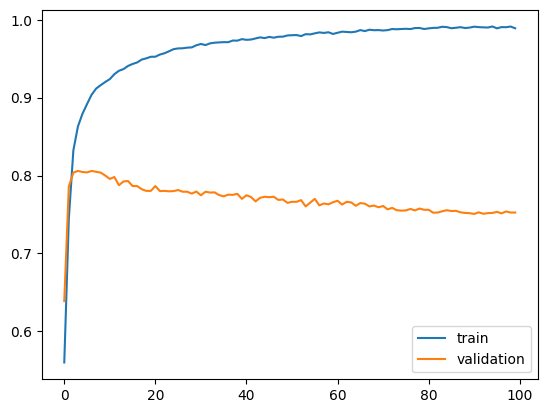

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()
plt.show()

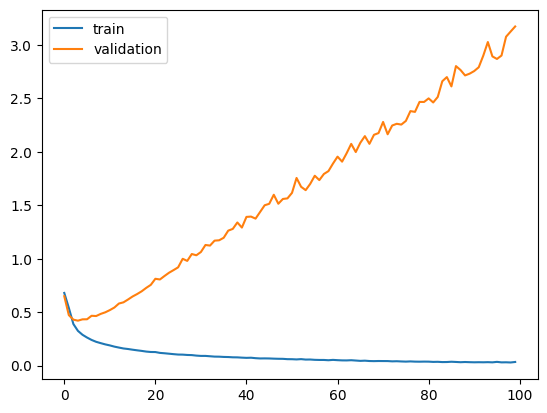

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()

어휘사전 크기 바꾸기

In [ ]:
wc = tokenizer.word_counts
sorted(wc.items(), key=lambda t: t[1],reverse = True )

In [ ]:
wc

In [20]:
from collections import OrderedDict
newlists = OrderedDict(sorted(wc.items(), key=lambda t: t[1],reverse = True ) )
# newlists

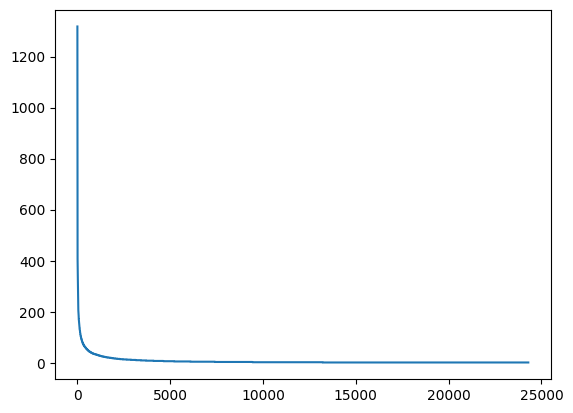

In [21]:
xs,ys = [],[]
curr_x = 1
for item in newlists:
  xs.append(curr_x)
  curr_x = curr_x+1
  ys.append(newlists[item])
plt.plot(xs,ys)
plt.show()

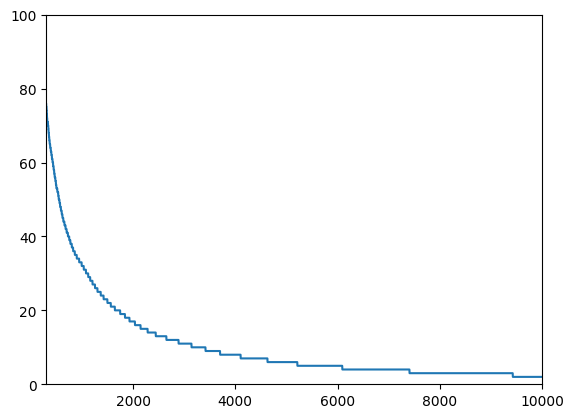

In [22]:
plt.plot(xs,ys)
plt.axis([300,10000,0,100])
plt.show()

In [ ]:
vocab_size = 2000
training_sequences

In [28]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [29]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [31]:
num_epochs = 30
history = model.fit(training_padded,training_labels,epochs=num_epochs,validation_data=(testing_padded, testing_labels) )

Epoch 1/30
719/719 [==============================] - 14s 18ms/step - loss: 0.6782 - accuracy: 0.5657 - val_loss: 0.6491 - val_accuracy: 0.6538
Epoch 2/30
719/719 [==============================] - 4s 6ms/step - loss: 0.5735 - accuracy: 0.7098 - val_loss: 0.5171 - val_accuracy: 0.7517
Epoch 3/30
719/719 [==============================] - 4s 6ms/step - loss: 0.4710 - accuracy: 0.7774 - val_loss: 0.4758 - val_accuracy: 0.7633
Epoch 4/30
719/719 [==============================] - 4s 5ms/step - loss: 0.4354 - accuracy: 0.7917 - val_loss: 0.4678 - val_accuracy: 0.7657
Epoch 5/30
719/719 [==============================] - 3s 4ms/step - loss: 0.4200 - accuracy: 0.7990 - val_loss: 0.4874 - val_accuracy: 0.7549
Epoch 6/30
719/719 [==============================] - 4s 5ms/step - loss: 0.4115 - accuracy: 0.8032 - val_loss: 0.4623 - val_accuracy: 0.7733
Epoch 7/30
719/719 [==============================] - 4s 5ms/step - loss: 0.4053 - accuracy: 0.8060 - val_loss: 0.4619 - val_accuracy: 0.7760
Epoc

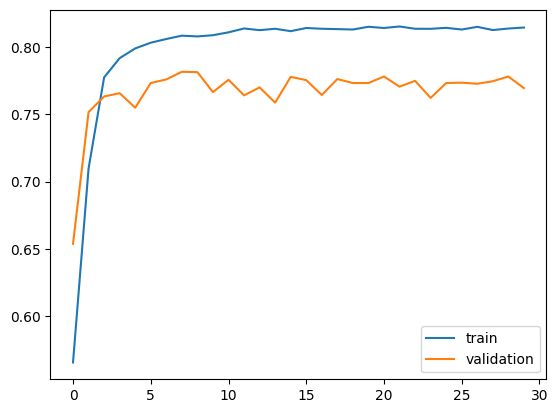

In [32]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()
plt.show()

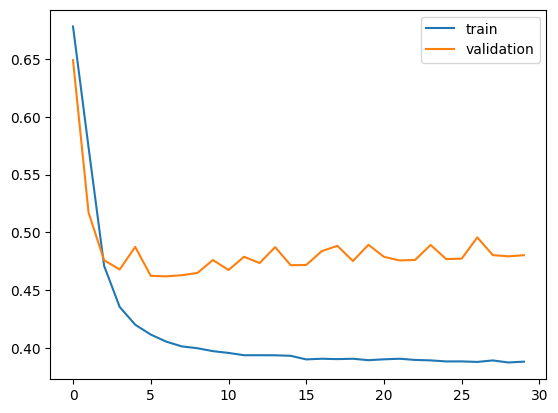

In [33]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()

임베딩 차원 바꾸기

In [35]:
embedding_dim = 7

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 30  #100q 수정
history = model.fit(training_padded,training_labels,epochs=num_epochs,validation_data=(testing_padded, testing_labels) )

Epoch 1/30
719/719 [==============================] - 11s 14ms/step - loss: 0.6812 - accuracy: 0.5598 - val_loss: 0.6598 - val_accuracy: 0.6161
Epoch 2/30
719/719 [==============================] - 4s 6ms/step - loss: 0.5903 - accuracy: 0.6904 - val_loss: 0.5295 - val_accuracy: 0.7414
Epoch 3/30
719/719 [==============================] - 3s 4ms/step - loss: 0.4821 - accuracy: 0.7743 - val_loss: 0.4794 - val_accuracy: 0.7638
Epoch 4/30
719/719 [==============================] - 4s 6ms/step - loss: 0.4420 - accuracy: 0.7925 - val_loss: 0.4861 - val_accuracy: 0.7541
Epoch 5/30
719/719 [==============================] - 3s 4ms/step - loss: 0.4230 - accuracy: 0.7993 - val_loss: 0.4633 - val_accuracy: 0.7743
Epoch 6/30
719/719 [==============================] - 3s 4ms/step - loss: 0.4142 - accuracy: 0.8015 - val_loss: 0.4620 - val_accuracy: 0.7749
Epoch 7/30
719/719 [==============================] - 4s 5ms/step - loss: 0.4067 - accuracy: 0.8079 - val_loss: 0.4620 - val_accuracy: 0.7754
Epoc

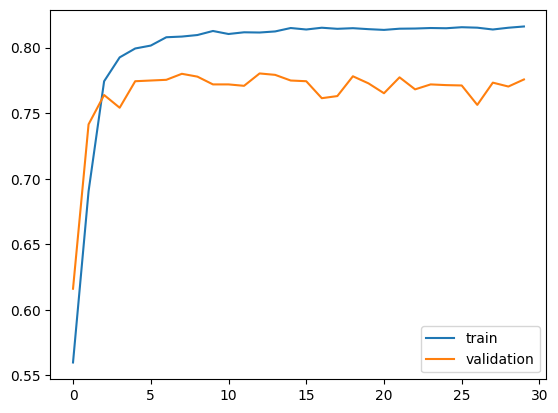

In [36]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()
plt.show()

모델 구조 변경하기

In [37]:
embedding_dim = 7

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 50  #100q 수정
history = model.fit(training_padded,training_labels,epochs=num_epochs,validation_data=(testing_padded, testing_labels) )

Epoch 1/50
719/719 [==============================] - 12s 13ms/step - loss: 0.6848 - accuracy: 0.5564 - val_loss: 0.6763 - val_accuracy: 0.5700
Epoch 2/50
719/719 [==============================] - 4s 6ms/step - loss: 0.6522 - accuracy: 0.6083 - val_loss: 0.6052 - val_accuracy: 0.6870
Epoch 3/50
719/719 [==============================] - 3s 5ms/step - loss: 0.5653 - accuracy: 0.7150 - val_loss: 0.5381 - val_accuracy: 0.7371
Epoch 4/50
719/719 [==============================] - 3s 4ms/step - loss: 0.5052 - accuracy: 0.7576 - val_loss: 0.4904 - val_accuracy: 0.7617
Epoch 5/50
719/719 [==============================] - 4s 6ms/step - loss: 0.4761 - accuracy: 0.7767 - val_loss: 0.4767 - val_accuracy: 0.7644
Epoch 6/50
719/719 [==============================] - 3s 4ms/step - loss: 0.4570 - accuracy: 0.7864 - val_loss: 0.4690 - val_accuracy: 0.7738
Epoch 7/50
719/719 [==============================] - 3s 4ms/step - loss: 0.4454 - accuracy: 0.7937 - val_loss: 0.4663 - val_accuracy: 0.7738
Epoc

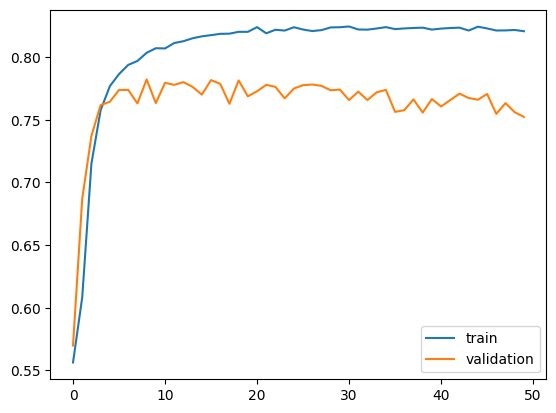

In [38]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()
plt.show()

규제 알고리즘

In [ ]:
embedding_dim = 7

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8,activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 30  #100q 수정
history = model.fit(training_padded,training_labels,epochs=num_epochs,validation_data=(testing_padded, testing_labels) )

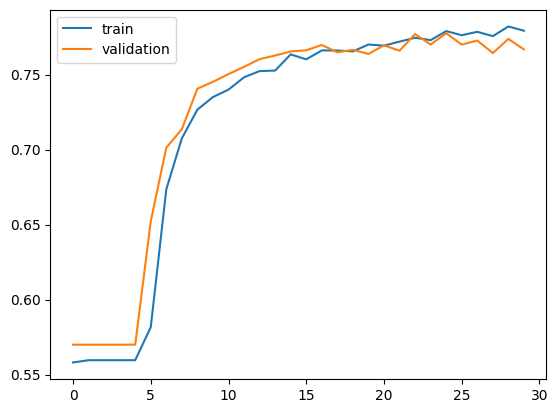

In [40]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()
plt.show()

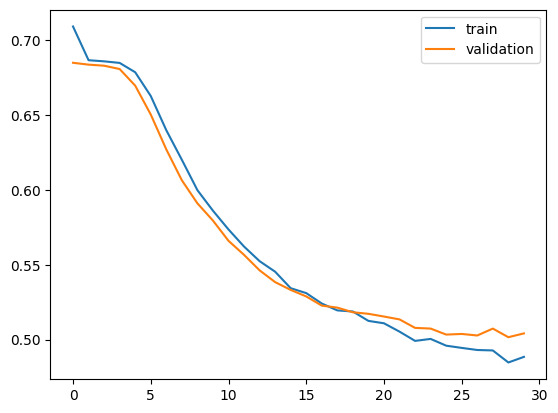

In [41]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()